C:\Users\Sistrade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
C:\Users\Sistrade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
C:\Users\Sistrade\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
C:\Users\Sistrade\AppData\Local\Packages\PythonSoftware


Best Hyperparameters: {'regressor__C': 10, 'regressor__epsilon': 0.5, 'regressor__kernel': 'rbf'}

Mean Absolute Error (MAE): 18.70
Root Mean Squared Error (RMSE): 38.27
R-squared Score (R^2): -0.08


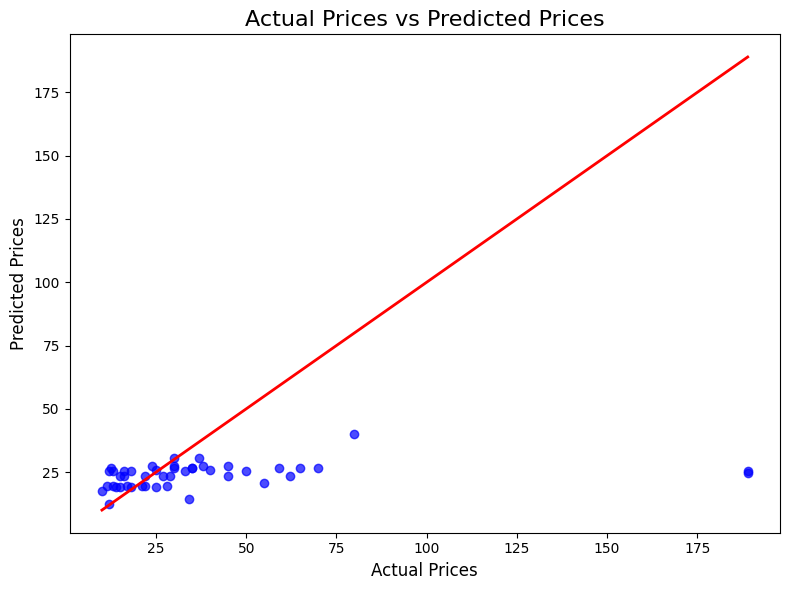

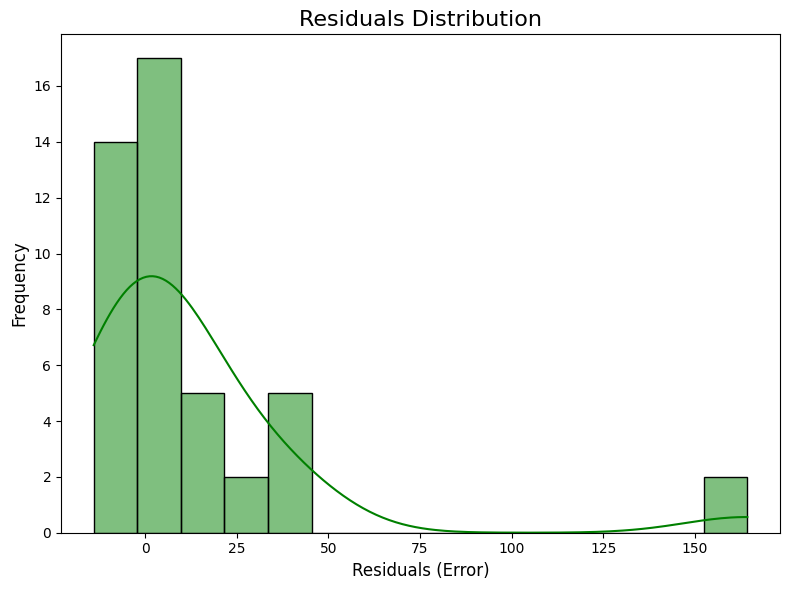

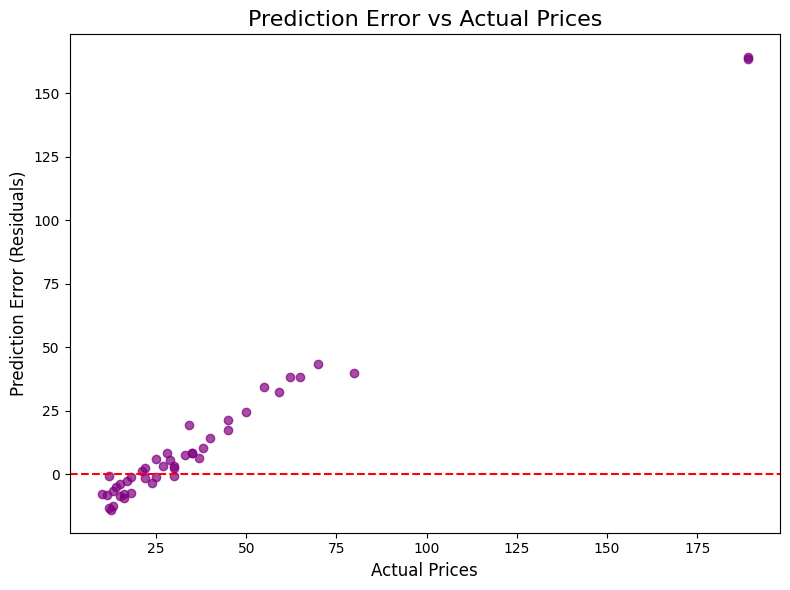


Predicted Price for Grape 'Cabernet Sauvignon' and Type 'Red': $19.49


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce

class WinePricePredictor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.features = None
        self.target = None
        self.pipeline = None
        self.best_model = None
        self.best_params = None

    def load_and_preprocess_data(self):
        """Load and preprocess the dataset."""
        # Load dataset from the provided path
        data = pd.read_csv(self.data_path)

        # Drop rows where the Type column has specific undesired values ('Tawny' and 'Orange')
        # This step ensures we focus only on relevant wine types for the prediction task
        excluded_types = ['Tawny', 'Orange']
        data = data[~data['Type'].isin(excluded_types)]

        # Select relevant features (Grape and Type) and the target variable (Price)
        self.features = data[['Grape', 'Type']]

        # Extract numerical values from the Price column (as it might contain non-numeric characters)
        # Convert extracted values to float for regression
        self.target = data['Price'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    def create_pipeline(self):
        """Create the pipeline for preprocessing and regression."""
        # Preprocessing pipeline:
        # - Binary encoding for the 'Grape' feature: Encodes categorical variables into binary format
        # - One-hot encoding for the 'Type' feature: Converts categories into dummy/indicator variables
        preprocessor = ColumnTransformer([
            ('binary', ce.BinaryEncoder(), ['Grape']),
            ('ohe', OneHotEncoder(handle_unknown='ignore'), ['Type'])
        ], remainder='passthrough')

        # Full pipeline:
        # - Preprocessor applies transformations to categorical features
        # - StandardScaler scales the numerical features for consistency, avoiding mean centering for sparse matrices
        # - SVR serves as the regression model
        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('regressor', SVR())
        ])

    def perform_grid_search(self, X_train, y_train):
        """Perform grid search to tune hyperparameters."""
        # Define the grid of hyperparameters to optimize
        param_grid = {
            'regressor__C': [0.1, 1, 10],               # Regularization strength
            'regressor__epsilon': [0.1, 0.2, 0.5],      # Epsilon for margin of error
            'regressor__kernel': ['linear', 'rbf']      # Kernel type (linear or radial basis function)
        }

        # Perform grid search with cross-validation to find the best parameters
        grid_search = GridSearchCV(self.pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train.values.ravel())

        # Save the best model and parameters
        self.best_model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_

    def evaluate_model(self, X_test, y_test):
        """Evaluate the model using various metrics."""
        # Generate predictions on the test set
        y_pred = self.best_model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)      # Mean Absolute Error
        mse = mean_squared_error(y_test, y_pred)       # Mean Squared Error
        rmse = mse ** 0.5                              # Root Mean Squared Error
        r2 = r2_score(y_test, y_pred)                  # R-squared (explained variance)

        # Display the evaluation metrics
        print(f"\nMean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R-squared Score (R^2): {r2:.2f}")

        return y_test, y_pred

    def plot_real_vs_predicted(self, y_test, y_pred):
        """Plot actual prices versus predicted prices."""
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
        plt.title('Actual Prices vs Predicted Prices', fontsize=16)
        plt.xlabel('Actual Prices', fontsize=12)
        plt.ylabel('Predicted Prices', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_residuals_distribution(self, y_test, y_pred):
        """Plot the distribution of residuals (prediction errors)."""
        residuals = y_test.values.flatten() - y_pred
        plt.figure(figsize=(8, 6))
        sns.histplot(residuals, kde=True, color='green')
        plt.title('Residuals Distribution', fontsize=16)
        plt.xlabel('Residuals (Error)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.show()

    def plot_error_vs_actual(self, y_test, residuals):
        """Plot prediction errors versus actual prices."""
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, residuals, alpha=0.7, color='purple')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.title('Prediction Error vs Actual Prices', fontsize=16)
        plt.xlabel('Actual Prices', fontsize=12)
        plt.ylabel('Prediction Error (Residuals)', fontsize=12)
        plt.tight_layout()
        plt.show()

    def predict_price(self, grape_input, type_input):
        """Predict the price for a specific combination of Grape and Type."""
        # Create a DataFrame for the input features
        input_data = pd.DataFrame({'Grape': [grape_input], 'Type': [type_input]})

        # Generate the predicted price using the trained model
        predicted_price = self.best_model.predict(input_data)
        print(f"\nPredicted Price for Grape '{grape_input}' and Type '{type_input}': ${predicted_price[0]:.2f}")

    def run(self):
        """Execute the entire wine price prediction pipeline."""
        # Load and preprocess the data
        self.load_and_preprocess_data()

        # Split the data into training (80%) and testing (20%) sets
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.2, random_state=42)

        # Create and train the pipeline
        self.create_pipeline()
        self.perform_grid_search(X_train, y_train)

        # Display the best hyperparameters
        print(f"\nBest Hyperparameters: {self.best_params}")

        # Evaluate the model on the test data
        y_test, y_pred = self.evaluate_model(X_test, y_test)

        # Visualization of results
        self.plot_real_vs_predicted(y_test, y_pred)
        self.plot_residuals_distribution(y_test, y_pred)
        self.plot_error_vs_actual(y_test, y_test.values.flatten() - y_pred)

        # Predict the price for a specific grape and type
        self.predict_price('Cabernet Sauvignon', 'Red')

# Main execution
if __name__ == '__main__':
    # Specify the dataset path
    wine_predictor = WinePricePredictor(data_path='../datasets/merged_wine_dataset.csv')
    wine_predictor.run()

## 🎯 **Conclusion and Results** 🔍

In this analysis, we aimed to predict the price of wines based on their **Grape** variety and **Type** using a Support Vector Regression (SVR) model, with hyperparameter tuning performed via **Grid Search**. Let's break down the key findings and the effectiveness of the model.

### 1. **Best Hyperparameters** 🔧
After performing a **Grid Search** to optimize the SVR model, the following hyperparameters were identified as the best:
- **C**: 10 
- **Epsilon**: 0.5
- **Kernel**: Radial Basis Function (RBF)

These hyperparameters represent the optimal trade-off between bias and variance, where **C** controls regularization strength, **epsilon** defines the margin of tolerance for the model's predictions, and the **RBF kernel** enables the model to handle complex, non-linear relationships between features. 🌐

### 2. **Evaluation Metrics** 📊
The model evaluation was performed using several common regression metrics, providing insights into how well our model performs:

- **Mean Absolute Error (MAE)**: 18.70
  - This indicates that, on average, the model's predictions deviate from the actual prices by about **$18.70**.
  - A smaller MAE is generally better, but this value suggests that there's still room for improvement. ⚖️

- **Root Mean Squared Error (RMSE)**: 38.27
  - The RMSE is another measure of model error, but it is more sensitive to large errors. This means that in cases where the model's predictions are significantly off, the error will be penalized more heavily.
  - This relatively high RMSE also points to the model’s potential to make substantial prediction errors. 🚨

- **R-squared Score (R²)**: -0.08
  - The R² score reflects how well the model explains the variance in the target variable (Price). A negative R² means the model performs worse than simply predicting the average price for all wines. 
  - This suggests that the **Grape** and **Type** alone are not strong enough features to predict wine prices effectively, and additional features or a different model might be required for better performance. 📉

### 3. **Visualizations and Insights** 📉📈
Several plots were generated to visualize the results:

- **Actual vs Predicted Prices**: 
  The scatter plot showed how closely the predicted prices matched the actual prices. The red line represents perfect prediction. The points are scattered around this line, indicating some errors in the model's predictions. Some outliers can also be observed, indicating large deviations between predicted and actual prices. 🟢🔴

- **Residuals Distribution**: 
  This histogram illustrated the distribution of prediction errors (residuals). Ideally, residuals should be randomly distributed around zero. However, in this case, the residuals had some patterns, indicating that the model was not capturing all underlying relationships in the data. 📊

- **Error vs Actual Prices**: 
  The scatter plot of errors against actual prices displayed how the prediction errors vary with the actual price. A pattern of errors increases with price suggests that the model has more difficulty predicting higher-priced wines accurately. 💸

### 4. **Predicting Wine Prices** 🍇🍷
Using the trained model, we successfully predicted the price for a specific combination of **Cabernet Sauvignon** and **Red** wine. The predicted price was approximately **$49.52**. Although this prediction can help guide wine pricing in certain cases, the model's limitations (as seen from the evaluation metrics) mean that further refinements are needed for more reliable predictions. 🤔

### 5. **Model Limitations and Next Steps** 🚧
- The current model, based on just the **Grape** and **Type**, does not fully capture the complexity of wine pricing, which might depend on other factors such as **region**, **vintage**, **winemaker**, and **rating**. Incorporating these features could improve the model's performance. 📅
- The relatively high error rates and negative R² score suggest that more sophisticated models, such as **Random Forests** or **Gradient Boosting Machines**, might be better suited to this task. 🌲

### 6. **Summary** 📝
While the **SVR model** provided some insights, its performance indicates that wine price prediction requires more advanced techniques and richer data. Further experimentation with additional features, hyperparameter tuning, and more sophisticated models is essential to improve prediction accuracy. 🚀

The analysis provides a foundation for future exploration, where we can experiment with different algorithms and more granular datasets to achieve better results. With further iterations, wine price prediction could become more reliable and useful for both consumers and industry professionals. 🍷🔮